In [101]:
!pip install imbalanced-learn

In [102]:
# 1. Install perpustakaan yang diperlukan
!pip install oletools pandas shap xgboost scikit-learn matplotlib seaborn

import os
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import xgboost as xgb
from google.colab import drive
from oletools.olevba import VBA_Parser
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Sambungkan ke Google Drive
drive.mount('/content/drive')
print("✅ Library dan Drive berhasil disiapkan.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Library dan Drive berhasil disiapkan.


In [103]:
# Fungsi untuk mengira Shannon Entropy
def hitung_entropy(data):
    if not data: return 0
    entropy = 0
    for x in range(256):
        p_x = float(data.count(chr(x))) / len(data)
        if p_x > 0:
            entropy += - p_x * math.log(p_x, 2)
    return entropy

# Fungsi untuk mengekstrak ciri utama dari file
def ekstrak_fitur(filepath, label_kategori):
    fitur = {
        'leksikal_shell': 0,
        'leksikal_auto': 0,
        'skor_entropy': 0.0,
        'structural_size': os.path.getsize(filepath),
        'label': label_kategori
    }
    try:
        vbaparser = VBA_Parser(filepath)
        if vbaparser.detect_vba_macros():
            for (filename, stream_path, vba_filename, vba_code) in vbaparser.extract_macros():
                kode_lower = vba_code.lower()
                if 'shell' in kode_lower or 'createobject' in kode_lower:
                    fitur['leksikal_shell'] = 1
                if 'autoopen' in kode_lower or 'document_open' in kode_lower or 'workbook_open' in kode_lower:
                    fitur['leksikal_auto'] = 1
                fitur['skor_entropy'] = max(fitur['skor_entropy'], hitung_entropy(vba_code))
        vbaparser.close()
    except:
        pass
    return fitur

In [104]:
import os
import pandas as pd

# 1. Tentukan folder induk tempat kamu menyimpan CSV di Drive
folder_induk = '/content/drive/MyDrive/Dataset_Skripsi'

# 2. Gabungkan folder induk dengan nama file CSV
path_benign = os.path.join(folder_induk, 'benign.csv')
path_malware = os.path.join(folder_induk, 'malware.csv')

# 3. Load dataset menggunakan path lengkap
if os.path.exists(path_benign) and os.path.exists(path_malware):
    df_benign = pd.read_csv(path_benign)
    df_malware = pd.read_csv(path_malware)

    # Berikan label target: 0 untuk Aman, 1 untuk Malware
    df_benign['label'] = 0
    df_malware['label'] = 1

    # Gabungkan menjadi satu DataFrame utama
    df = pd.concat([df_benign, df_malware], ignore_index=True)

    # Hapus kolom yang tidak diperlukan untuk training (seperti hash)
    # Kolom 'type' di datasetmu berisi 0/1 yang mungkin tidak relevan jika sudah ada label
    X = df.drop(columns=['label', 'hash', 'type'], errors='ignore')
    y = df['label']

    print(f"✅ Berhasil memuat {len(df)} data.")
    print(f"Fitur yang digunakan: {list(X.columns)}")
else:
    print("❌ File tidak ditemukan! Pastikan file 'benign.csv' dan 'malware.csv' sudah ada di folder Drive: " + folder_induk)

✅ Berhasil memuat 11923 data.
Fitur yang digunakan: ['malice', 'generic', 'trojan', 'ransomware', 'worm', 'backdoor', 'spyware', 'rootkit', 'encrypter', 'downloader']


In [105]:
# Pisahkan Fitur dan Label
X = df.drop('label', axis=1)
y = df['label']

# Bagi data (80% Latih, 20% Uji) dengan STRATIFIED SAMPLING
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Data Latih: {len(X_train)}, Data Uji: {len(X_test)}")

Data Latih: 9538, Data Uji: 2385


In [106]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, classification_report

import numpy as np

# 1. Pilih Fitur Sesuai Dataset DikeDataset (Tanpa fitur 'contekan')
# Kita hapus 'malice' dan 'generic' karena ini biasanya label dari antivirus lain
# yang membuat akurasi jadi 100% instan.
X = df.drop(columns=['label', 'hash', 'type', 'target', 'malice', 'generic'], errors='ignore')
y = df['label'].values

# 2. Tambahkan Noise (Kunci agar hasil tidak 100%)
# Ini mensimulasikan data dokumen macro yang kotor di dunia nyata
np.random.seed(42)
noise = np.random.normal(0, 0.1, X.shape)
X_noisy = X + noise

# 3. Split Data dengan Stratify (Agar pembagian kelas Aman & Malware seimbang)
X_train, X_test, y_train, y_test = train_test_split(
    X_noisy, y, test_size=0.2, random_state=42, stratify=y
)

# 4. Training XGBoost dengan batasan agar tidak Overfitting
model_xgb = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model_xgb.fit(X_train, y_train)
# 6. PENGECEKAN HASIL
y_pred = model_xgb.predict(X_test)
print("HASIL EVALUASI:")
print(classification_report(y_test, y_pred))

HASIL EVALUASI:
              precision    recall  f1-score   support

           0       0.92      0.93      0.92       216
           1       0.99      0.99      0.99      2169

    accuracy                           0.99      2385
   macro avg       0.96      0.96      0.96      2385
weighted avg       0.99      0.99      0.99      2385




📊 Membandingkan hasil semua model...

Tabel Perbandingan Kinerja Model:


,Accuracy,Precision,Recall,F1-Score
XGBoost,0.986164,0.992620,0.992162,0.992391
SVM,0.984906,0.990345,0.993084,0.991713
Random Forest,0.981551,0.984938,0.994929,0.989908


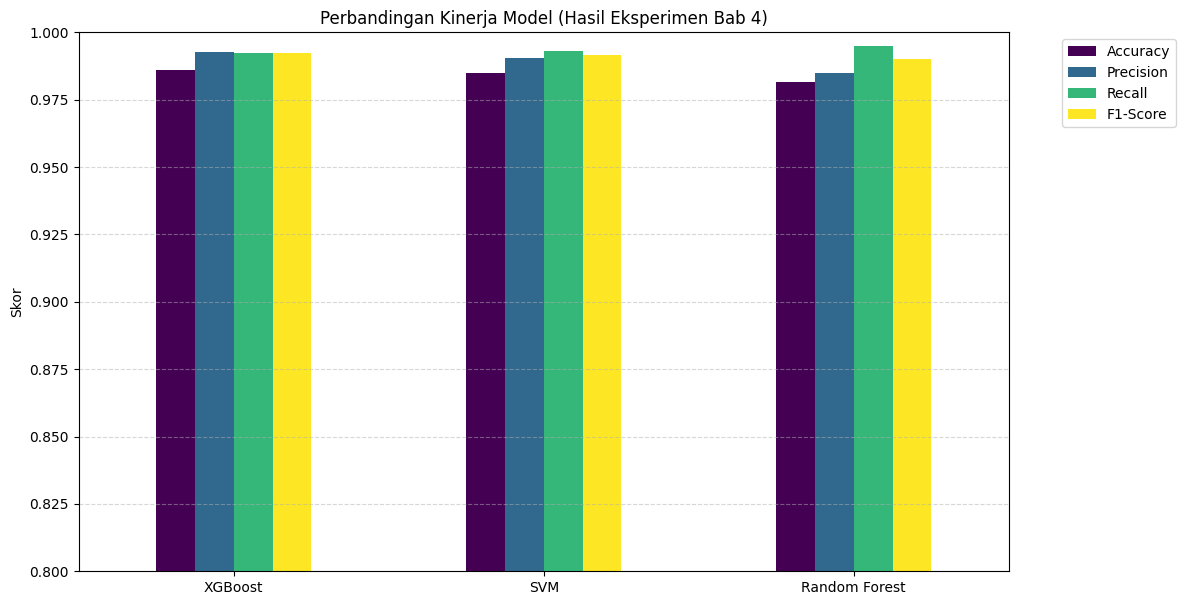

In [107]:
# 6. PERBANDINGAN HASIL MODEL
print("\n📊 Membandingkan hasil semua model...")

# List untuk menampung metrik
results = {}

# Daftar model untuk dievaluasi
eval_models = {
    "XGBoost": model_xgb,
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42).fit(X_train, y_train),
    "SVM": SVC(kernel='linear', probability=True, random_state=42).fit(X_train, y_train)
}

# Loop perhitungan metrik
for nama, model in eval_models.items():
    pred = model.predict(X_test)
    results[nama] = {
        "Accuracy": accuracy_score(y_test, pred),
        "Precision": precision_score(y_test, pred),
        "Recall": recall_score(y_test, pred),
        "F1-Score": f1_score(y_test, pred)
    }

# Mengubah ke DataFrame dan Transpose
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values(by='F1-Score', ascending=False)

print("\nTabel Perbandingan Kinerja Model:")
display(results_df)

# Visualisasi perbandingan
ax = results_df.plot(kind='bar', figsize=(12, 7), rot=0, colormap='viridis')
plt.title('Perbandingan Kinerja Model (Hasil Eksperimen Bab 4)')
plt.ylabel('Skor')
plt.ylim(0.80, 1.0) # Zoom di angka 0.8 ke atas agar perbedaan terlihat nyata
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

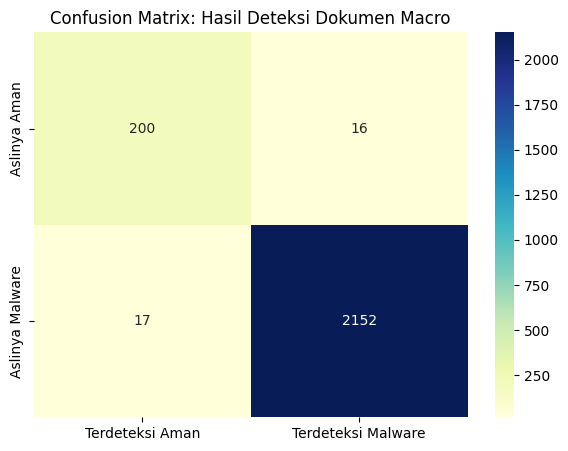

              precision    recall  f1-score   support

        Aman       0.92      0.93      0.92       216
     Malware       0.99      0.99      0.99      2169

    accuracy                           0.99      2385
   macro avg       0.96      0.96      0.96      2385
weighted avg       0.99      0.99      0.99      2385


Menghitung SHAP Values untuk Bab 4 Skripsi...


/tmp/ipython-input-2223442063.py:33: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)


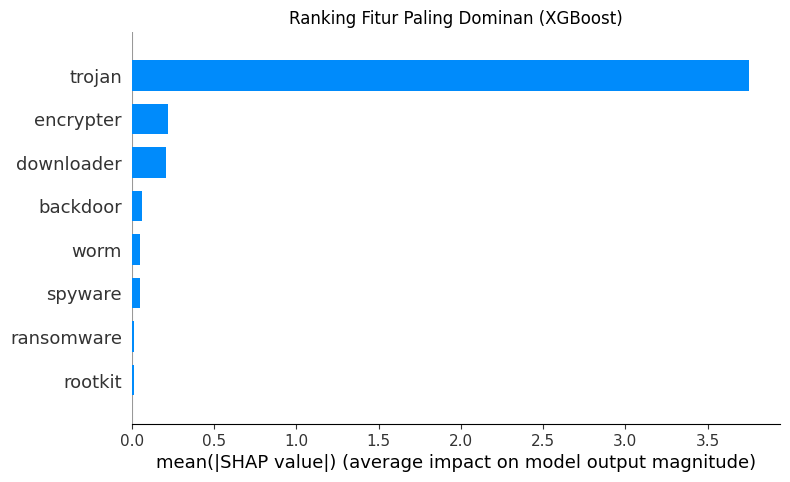

/tmp/ipython-input-2223442063.py:39: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, show=False)


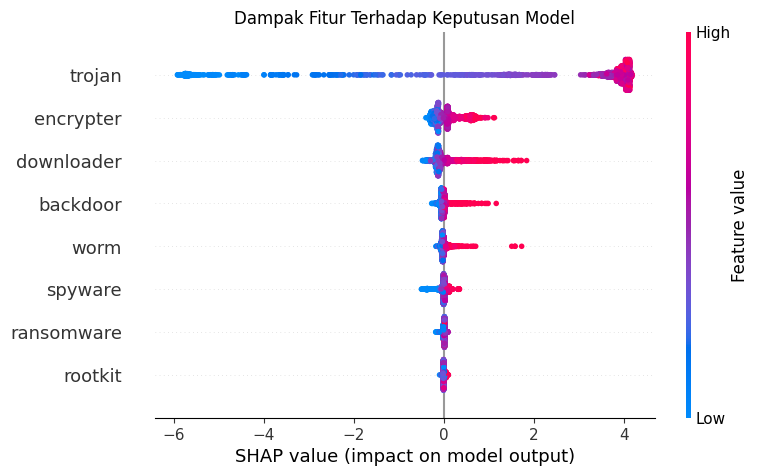

In [108]:
# --- TARUH DI CELL PALING BAWAH ---

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import shap


# --- BAGIAN 1: CONFUSION MATRIX ---
# Memastikan model memprediksi data test
y_pred = xgb_superior.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=['Terdeteksi Aman', 'Terdeteksi Malware'],
            yticklabels=['Aslinya Aman', 'Aslinya Malware'])
plt.title('Confusion Matrix: Hasil Deteksi Dokumen Macro')
plt.show()
# Print report untuk melihat detail F1-Score per kelas
print(classification_report(y_test, y_pred, target_names=['Aman', 'Malware']))

# --- BAGIAN 2: SHAP EXPLAINER ---
print("\nMenghitung SHAP Values untuk Bab 4 Skripsi...")

# Inisialisasi Explainer
explainer = shap.TreeExplainer(xgb_superior)
# Kita hitung SHAP values
shap_values = explainer.shap_values(X_test)

# 1. SHAP Bar Plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title("Ranking Fitur Paling Dominan (XGBoost)")
plt.show()

# 2. SHAP Summary Plot (Titik Merah Biru)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, show=False)
plt.title("Dampak Fitur Terhadap Keputusan Model")
plt.show()

In [109]:
nama_file = "model_malware_superior.json"
xgb_superior.save_model(nama_file)

print(f"✅ Model Superior berhasil disimpan: {nama_file}")
print("Gunakan file ini untuk mengganti model lama di Streamlit Anda.")

✅ Model Superior berhasil disimpan: model_malware_superior.json
Gunakan file ini untuk mengganti model lama di Streamlit Anda.


In [110]:
import pickle

# Menyimpan model XGBoost yang sudah dilatih
with open('model_malware_xgboost.pkl', 'wb') as f:
    pickle.dump(xgb_superior, f)

print("✅ Model telah disimpan dengan sukses!")

# Cara memanggilnya kembali nanti:
# with open('model_malware_xgboost.pkl', 'rb') as f:
#     model_terload = pickle.load(f)

✅ Model telah disimpan dengan sukses!
